# Assignment 2
#### leyu,lin(Jack) 817372912

[![]( https://img.shields.io/badge/Python-v3.7-orange)]()
[![](https://img.shields.io/badge/pandas-v1-blue)]()

### Zip File Paths

In [1]:
green_zip = 'green.zip'

### Imports

### Number of virtual cores you can use

In [3]:
print('Virtual Cores: ',multiprocessing.cpu_count())

Virtual Cores:  8


### Timer function

In [4]:
class Timer:
    def __init__(self):
        "Timer - Start a timer"
        self.s_per_min = 60.0  # Number seconds per minute
        self.start = time.time()

    def elapsed_s(self):
        "elapsed_s - Seconds elapsed since start (wall clock time)"
        return time.time() - self.start

    def elapsed_min(self):
        "elapsed_min - Minutes elapsed since start (wall clock time)"

        # Get elapsed seconds and convert to minutes
        return self.elapsed_s() / self.s_per_min

### Convert data to HDF5 
(cited from: https://nbviewer.jupyter.org/github/vaexio/vaex-examples/blob/master/medium-airline-data-eda/airline-original-data-conversion.ipynb)

In [5]:
# select columns we need
headers = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
           'passenger_count','trip_distance', 'fare_amount', 'trip_type']

In [6]:
# Set up zip files to be opened and converted
file = ZipFile(green_zip)

# Setting up directories'
output = 'green.hdf'

#list of datafame need combine
file_list=[]

In [8]:
# Check if a converted file already exists: if it does skip it, otherwise read in the raw csv and convert it
if (os.path.exists(output) and os.path.isfile(output)):
    pass
else:
    for text_file in file.infolist():
        if text_file.filename.endswith('.csv'):
            chunks = pd.read_csv(file.open(text_file.filename), 
                            encoding='latin',
                            usecols=lambda x: x.lower() in headers)
            file_list.append(chunks)
            
    #combine all list of dataframe for mistach columns fill with value 0
    pandas_df = pd.concat(file_list,ignore_index=True).fillna(0)

    # Importing the data from pandas to vaex
    vaex_df = vaex.from_pandas(pandas_df, copy_index=False)
        
    # Export the data with vaex to hdf5
    vaex_df.export_hdf5(path=output, progress=False)

### HDF5 file path

In [9]:
green_hdf5 = 'green.hdf' 

In [10]:
#analysis interested area
vaex_df = vaex.open (green_hdf5)

long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

df_selected_area = vaex_df[(vaex_df.Pickup_longitude > long_min) & 
                           (vaex_df.Pickup_longitude < long_max) & 
                           (vaex_df.Dropoff_longitude > long_min) & 
                           (vaex_df.Dropoff_longitude < long_max) &
                           (vaex_df.Pickup_latitude > lat_min) & 
                           (vaex_df.Pickup_latitude < lat_max) & 
                           (vaex_df.Dropoff_latitude > lat_min) & 
                           (vaex_df.Dropoff_latitude < lat_max)]
df_selected_area.describe()

,passenger_count,trip_distance,fare_amount,trip_type,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
count,18164870,18164870,18164870,18164870,18164870,18164870,18164870,18164870,18164870,18164870,18164870
NA,0,0,0,0,0,0,0,0,0,0,0
mean,0.0,0.0,0.0,0.0,-73.93638217124736,40.74811036847585,-73.93523574103646,40.74603972073462,1.364291954745616,2.8127890147297117,12.093477086266054
std,0,0,0,0,0.0413889,0.0565158,0.0483541,0.057172,1.03308,2.82204,9.60816
min,0,0,0,0,-74.0499,40.58,-74.05,40.58,0,0,-499
max,0,0,0,0,-73.75,40.9,-73.75,40.9,9,832.2,3498.5


### Notes
My answer for vaex base on reading
* cited from (https://towardsdatascience.com/how-to-analyse-100s-of-gbs-of-data-on-your-laptop-with-python-f83363dda94)

## 1. Plot the number of unique trips with certain number of passengers in the entire green taxi data


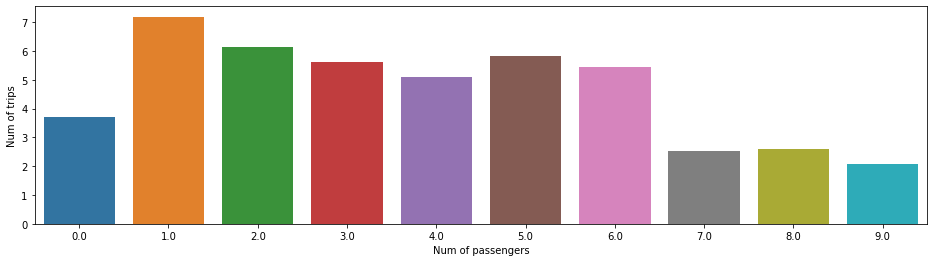

In [11]:
#vaex
t = Timer()
num_passenger = df_selected_area.Passenger_count.value_counts()
vaex_q1_time = t.elapsed_s()

#pandas
t = Timer()
pd_df = df_selected_area.to_pandas_df()
pd_df.groupby('Passenger_count').size()
pd_q1_time = t.elapsed_s()

#dask with muti-processs 4 process
dd_df = dd.from_pandas(pd_df,npartitions = 12)
t = Timer()
dd_df.groupby('Passenger_count').count().compute(scheduler='processes',num_workers=4)
dask_q1_time_muti4 = t.elapsed_s()

#dask with muti-processs 3 process
dd_df = dd.from_pandas(pd_df,npartitions = 14)
t = Timer()
dd_df.groupby('Passenger_count').count().compute(scheduler='processes',num_workers=3)
dask_q1_time_muti3= t.elapsed_s()

#dask with muti-processs 2 process
dd_df = dd.from_pandas(pd_df,npartitions = 16)
t = Timer()
dd_df.groupby('Passenger_count').count().compute(scheduler='processes',num_workers=2)
dask_q1_time_muti2= t.elapsed_s()

#dask with single process
t = Timer()
dd_df.groupby('Passenger_count').count().compute()
dask_q1_time_single = t.elapsed_s()

#plot 
plt.figure(figsize=(16,4))
sns.barplot(x=num_passenger.index, y=np.log10(num_passenger.values))
plt.xlabel('Num of passengers')
plt.ylabel('Num of trips')
plt.show()

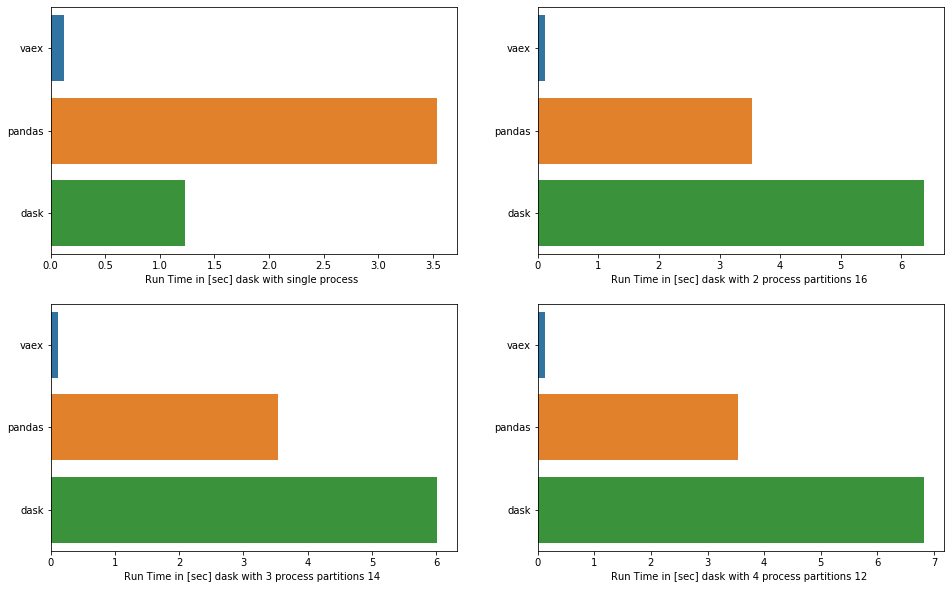

In [12]:
#Plot Performance comparsion for Q1 
methods = ['vaex','pandas','dask']
time_list = [vaex_q1_time,pd_q1_time,dask_q1_time_single]
plt.figure(figsize=(16,10))
plt.subplot(221)
sns.barplot(x= time_list, y= methods)
plt.xlabel('Run Time in [sec] dask with single process ')

plt.subplot(222)
time_list = [vaex_q1_time,pd_q1_time,dask_q1_time_muti2]
sns.barplot(x= time_list, y= methods)
plt.xlabel('Run Time in [sec] dask with 2 process partitions 16 ')

plt.subplot(223)
time_list = [vaex_q1_time,pd_q1_time,dask_q1_time_muti3]
sns.barplot(x= time_list, y= methods)
plt.xlabel('Run Time in [sec] dask with 3 process partitions 14 ')

plt.subplot(224)
time_list = [vaex_q1_time,pd_q1_time,dask_q1_time_muti4]
sns.barplot(x= time_list, y= methods)
plt.xlabel('Run Time in [sec] dask with 4 process partitions 12 ')

plt.show()

### My thoughts on question 1
* Base on the figure above for performance of question 1. Vaex has increible speed under 0.3 sec can process so much data
* Muti-process dask was actully could slower than orginal pandas
* single process dask was much faster (I Try to figure out why)
* For dask, the Number of paritions related the number of process could be optimal

## 2.Filter out the trips longer than 100 miles and trips that claim more than 10 people

In [13]:
#vaex
t = Timer()
df_filtered = df_selected_area[ (df_selected_area.Passenger_count > 0) & 
                                (df_selected_area.Passenger_count < 10) & 
                                (df_selected_area.Trip_distance > 0) &
                                (df_selected_area.Trip_distance < 100)] 
vaex_q2_time = t.elapsed_s()
#pandas
t = Timer()
pd_df = pd_df[(pd_df['Passenger_count'] > 0) &
              (pd_df['Passenger_count'] < 10) & 
              (pd_df['Trip_distance'] > 0) &
              (pd_df['Trip_distance'] < 100)]

pd_q2_time = t.elapsed_s()

#dask with single
dd_df = dd.from_pandas(pd_df,npartitions = 12)
t = Timer()
dd_df = dd_df[ (dd_df.Passenger_count > 0) & 
                (dd_df.Passenger_count < 10) & 
                (dd_df.Trip_distance > 0) &
                (dd_df.Trip_distance < 100)].compute()
dask_q2_time_single = t.elapsed_s()

#dask with 3 procesor
dd_df = dd.from_pandas(pd_df,npartitions = 14)
t = Timer()
dd_df = dd_df[ (dd_df.Passenger_count > 0) & 
                (dd_df.Passenger_count < 10) & 
                (dd_df.Trip_distance > 0) &
                (dd_df.Trip_distance < 100)].compute(scheduler='processes',num_workers=3)
dask_q2_time_single = t.elapsed_s()

#dask with 2 processor
dd_df = dd.from_pandas(pd_df,npartitions = 16)
t = Timer()
dd_df = dd_df[ (dd_df.Passenger_count > 0) & 
                (dd_df.Passenger_count < 10) & 
                (dd_df.Trip_distance > 0) &
                (dd_df.Trip_distance < 100)].compute(scheduler='processes',num_workers=2)
dask_q2_time_muti2 = t.elapsed_s()

#dask with 4 procesor
dd_df = dd.from_pandas(pd_df,npartitions = 12)
t = Timer()
dd_df = dd_df[ (dd_df.Passenger_count > 0) & 
                (dd_df.Passenger_count < 10) & 
                (dd_df.Trip_distance > 0) &
                (dd_df.Trip_distance < 100)].compute(scheduler='processes',num_workers=4)
dask_q2_time_muti4 = t.elapsed_s()

#double check correctness
df_filtered.head(5)

#,passenger_count,trip_distance,fare_amount,trip_type,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount
0,0,0,0,0,-73.95,40.8272,-73.9524,40.824,1,0.25,3
1,0,0,0,0,-73.945,40.8086,-73.9459,40.8073,1,0.04,2.5
2,0,0,0,0,-73.9516,40.8121,-73.9522,40.8125,1,0.26,3
3,0,0,0,0,-73.9521,40.7901,-73.9476,40.7954,1,0.51,4
4,0,0,0,0,-73.9139,40.683,-73.9139,40.6848,5,0.26,3


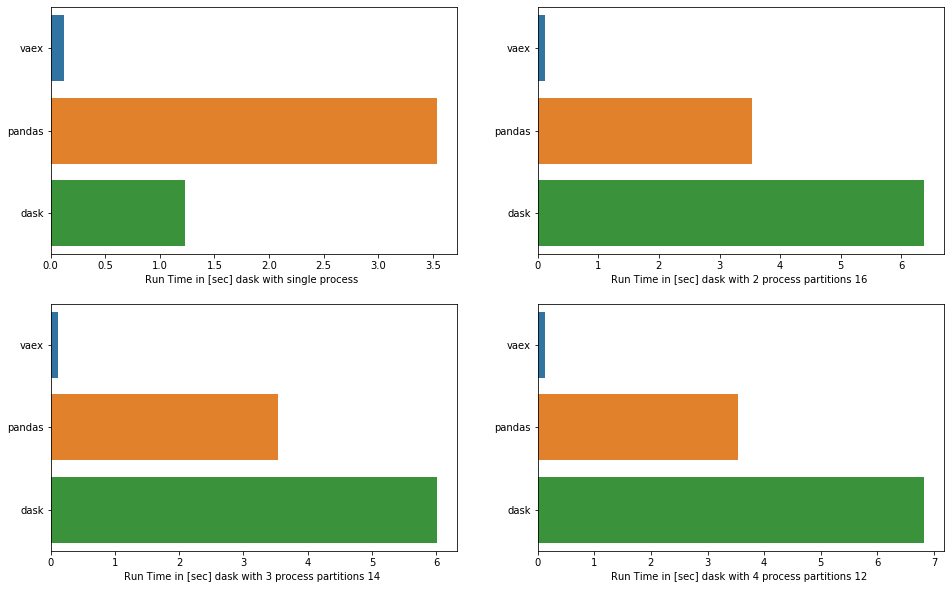

In [14]:
#Plot Performance comparsion for Q2
methods = ['vaex','pandas','dask']
time_list = [vaex_q1_time,pd_q1_time,dask_q1_time_single]
plt.figure(figsize=(16,10))
plt.subplot(221)
sns.barplot(x= time_list, y= methods)
plt.xlabel('Run Time in [sec] dask with single process ')

plt.subplot(222)
time_list = [vaex_q1_time,pd_q1_time,dask_q1_time_muti2]
sns.barplot(x= time_list, y= methods)
plt.xlabel('Run Time in [sec] dask with 2 process partitions 16 ')

plt.subplot(223)
time_list = [vaex_q1_time,pd_q1_time,dask_q1_time_muti3]
sns.barplot(x= time_list, y= methods)
plt.xlabel('Run Time in [sec] dask with 3 process partitions 14 ')

plt.subplot(224)
time_list = [vaex_q1_time,pd_q1_time,dask_q1_time_muti4]
sns.barplot(x= time_list, y= methods)
plt.xlabel('Run Time in [sec] dask with 4 process partitions 12 ')

plt.show()

### My thoughts on question 2
* Similar to question 1 no suriprise here
* vaex has increible speed compare with other two

## 3.On the ﬁltered data produce a heat map by pick up location color coded by average fare amount

In [15]:
# add fare/distance columns
np.seterr(divide='ignore', invalid='ignore')
# vaex 
df_filtered['Fare_over_distance'] = df_filtered['Fare_amount']/df_filtered['Trip_distance']

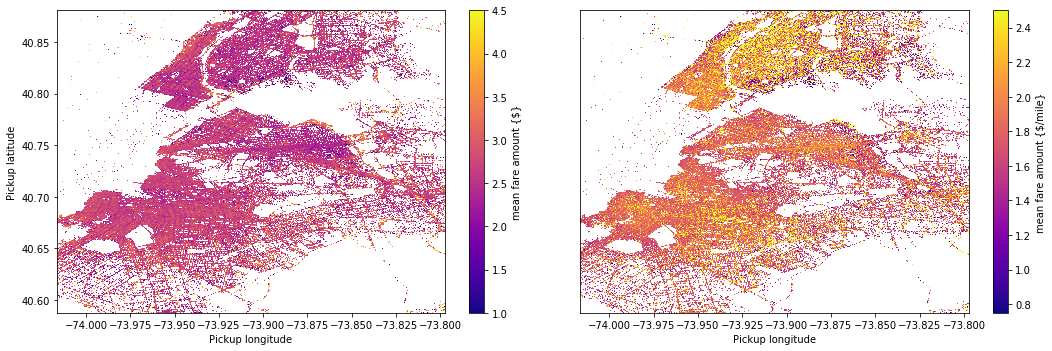

In [16]:
# vaex based on article
plt.figure(figsize=(15,5))
plt.subplot(121)

df_filtered.plot('Pickup_longitude','Pickup_latitude',what = 'mean(Fare_amount)',
                colormap = 'plasma', f= 'log1p',shape=512,colorbar=True,
                colorbar_label ='mean fare amount {$}',vmin=1,vmax=4.5)

plt.xlabel('Pickup longitude')
plt.ylabel('Pickup latitude')

plt.subplot(122)
df_filtered.plot('Pickup_longitude','Pickup_latitude',what = 'mean(Fare_over_distance)',
                colormap = 'plasma', f= 'log1p',shape=512,colorbar=True,
                colorbar_label ='mean fare amount {$/mile}',vmin=0.75,vmax=2.5)

plt.xlabel('Pickup longitude')
plt.ylabel('')
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

### For this question I wasnt able to unpack pandas dataframe to plot heatmap size was limited to Int32
I used top 10k rows for compare, Dask.datafram.compute is same as pandas dataframe,So I compare pandas and vaex

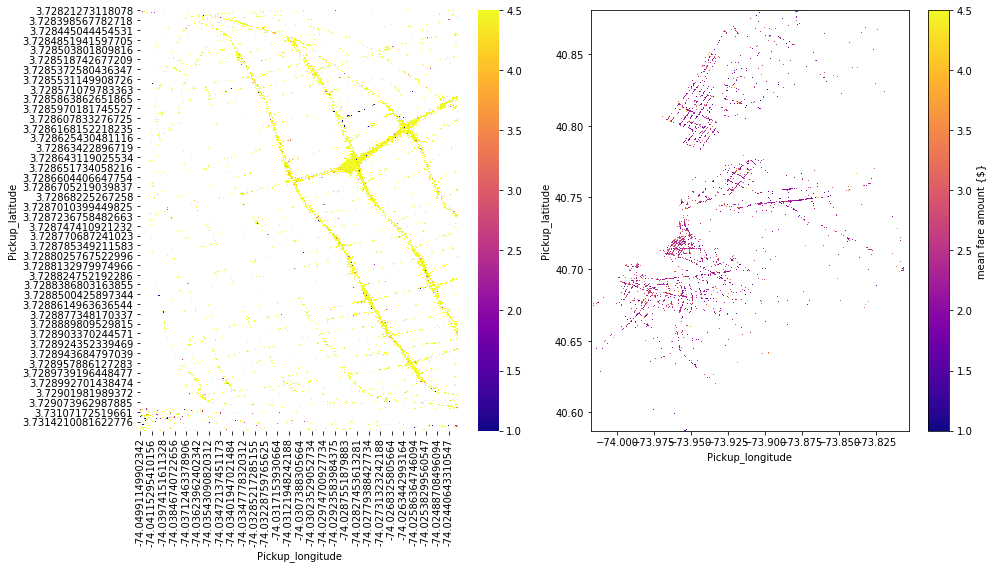

In [17]:
#pandas
plt.figure(figsize=(14,8))
plt.subplot(121)

# add fare/distance columns
df_long_lat= pd_df.groupby(['Pickup_longitude','Pickup_latitude']).mean().reset_index()

#scale in np.log1p
df_long_lat['Pickup_latitude'] = np.log1p(df_long_lat['Pickup_latitude'])
df_pivoted = df_long_lat.head(10000).pivot('Pickup_latitude','Pickup_longitude','Fare_amount')
sns.heatmap(df_pivoted,cmap='plasma',vmin=1,vmax=4.5)

plt.subplot(122)
#vaex
df_filtered.head(10000).plot('Pickup_longitude','Pickup_latitude',what = 'mean(Fare_amount)',
                        colormap = 'plasma', f= 'log1p',shape=512,colorbar=True,
                        colorbar_label ='mean fare amount {$}',vmin=1,vmax=4.5)
                 
plt.show()

### My thoughts on question 3
* Not sure how to compare. Since pandas wasnt able use same plot function, dask not has plot attribute
* Searborn heatmap wasnt suitable for large data set 
* pandas had limited for unpack data to Int32 in pivot table

##  4.Compute the arc distance for the ﬁltered data and plot the distribution number of trips of trip distance and arc distance. 

In [18]:
#computer arc distance
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180)** 2
            + np.cos(theta_1 * np.pi / 180)* np.cos(theta_2 * np.pi / 180) *np.sin((phi_2 - phi_1)/ 2 * np.pi / 180) **2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

In [19]:
#vaex data frame
df_filtered['arc_distance'] = arc_distance(df_filtered.Pickup_longitude,
                                           df_filtered.Pickup_latitude, 
                                           df_filtered.Dropoff_longitude, 
                                           df_filtered.Dropoff_latitude)
#pandas data frame
pd_df = df_filtered.to_pandas_df()

#dask data frame
dd_df = dd.from_pandas(pd_df,npartitions = 12)

[######################################--] 100.00% elapsed time  :     0.22s =  0.0m =  0.0h
[##############################----------] 100.00% elapsed time  :     2.36s =  0.0m =  0.0h 
[######################################--] 100.00% elapsed time  :     2.71s =  0.0m =  0.0h
 

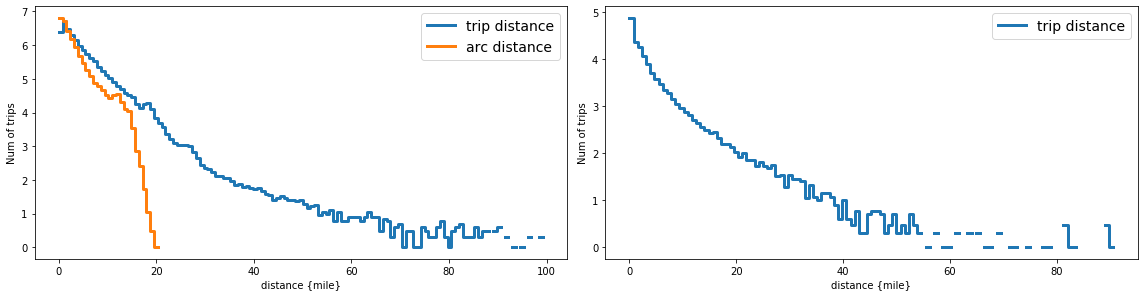

In [20]:
plt.figure(figsize=(16,12))
plt.subplot(321)

#vaex 1-D plot
df_filtered.plot1d('Trip_distance',shape=128,
                                   limits=[0,100],
                                   lw=3,
                                   f='log10',
                                   label='trip distance',
                                   progress=True)
df_filtered.plot1d('arc_distance',shape=128,
                                   limits=[0,100],
                                   lw=3,
                                   f='log10',
                                   label='arc distance',
                                   progress=True)
plt.legend(fontsize=14)
plt.xlabel('distance {mile}')
plt.ylabel('Num of trips')

plt.subplot(322)
df_filtered.plot1d('Trip_distance',shape=128,
                                   limits=[0,100],
                                   lw=3,
                                   f='log10',
                                   selection='arc_distance<0.06',
                                   label='trip distance',
                                   progress=True)
plt.legend(fontsize=14)
plt.xlabel('distance {mile}')
plt.ylabel('Num of trips')



plt.show()

### My thoughts on question 4
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I was try to manual set logscale to bins and use pandas
hist plot, but I am not sure the point of comparing vaex 1-D plot with pandas hist plot
So I omits my pandas plot. Since Vaex looks more clear

## Overall Notes
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The Vaex was hard to install, I run into lots trouble. PySpark wasn't working. (already metioned in lecture) <br/> 
For the plot not sure the run time comparsion,so many options we can use Seaborn.pyplot,pyltoy<br/>
I have learned the power of vaex on big datset, and dask was much slower on mutiprocessing